<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Functions</a></span></li></ul></li><li><span><a href="#Examples" data-toc-modified-id="Examples-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Examples</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Double-current" data-toc-modified-id="Double-current-2.0.0.1"><span class="toc-item-num">2.0.0.1&nbsp;&nbsp;</span>Double current</a></span></li><li><span><a href="#Single-trace" data-toc-modified-id="Single-trace-2.0.0.2"><span class="toc-item-num">2.0.0.2&nbsp;&nbsp;</span>Single trace</a></span></li><li><span><a href="#O-trace" data-toc-modified-id="O-trace-2.0.0.3"><span class="toc-item-num">2.0.0.3&nbsp;&nbsp;</span>O-trace</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Plot-with-the-three-together" data-toc-modified-id="Plot-with-the-three-together-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot with the three together</a></span></li><li><span><a href="#No-trace" data-toc-modified-id="No-trace-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>No trace</a></span></li></ul></div>

In [1]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns



from network import Protocol, Network, NetworkNMDA, NetworkManager
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

# Preamble

In [2]:
%matplotlib inline

np.set_printoptions(suppress=True, precision=5)

epsilon = 1e-7
vmin = -6.0
remove = 0.010

strict_maximum = True

dt = 0.001
tau_s = 0.010
tau_a = 0.250
g_I = 3.0
g_a = 2.0
G = 50.0

sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['figure.figsize'] = (12, 8)
lw = 10
ms = 22
alpha_graph = 0.3
colors = sns.color_palette()

## Functions

In [3]:
from connectivity_functions import softmax, get_w_pre_post, get_beta, strict_max
from connectivity_functions import create_weight_matrix

class Network_simple:
    def __init__(self, hypercolumns, minicolumns, G=1.0, tau_s=0.010, tau_z_pre=0.050, tau_z_post=0.005,
                 tau_a=0.250, g_a=1.0, g_I=10.0, sigma_out=0.0, epsilon=1e-60, g_beta=1.0, prng=np.random,
                 strict_maximum=True, perfect=False, normalized_currents=True):

        # Random number generator
        self.prng = prng
        self.sigma_out = sigma_out  # The variance that the system would have on the steady state if were to have it
        self.sigma_in = sigma_out * np.sqrt(2 / tau_s)  # Ornstein-Uhlenbeck process
        self.epsilon = epsilon

        # Network parameters
        self.hypercolumns = hypercolumns
        self.minicolumns = minicolumns

        self.n_units = self.hypercolumns * self.minicolumns

        # Network variables
        self.strict_maximum = strict_maximum
        self.perfect = perfect
        self.normalized_current = normalized_currents
        if self.normalized_current:
            self.normalized_constant = self.hypercolumns
        else:
            self.normalized_constant = 1.0

        # Dynamic Parameters
        self.tau_s = tau_s
        self.tau_a = tau_a
        self.r = self.tau_s / self.tau_a
        self.g_beta = g_beta
        self.g_a = g_a
        self.g_I = g_I
        self.tau_z_pre = tau_z_pre
        self.tau_z_post = tau_z_post
        self.G = G

        # State variables
        self.o = np.full(shape=self.n_units, fill_value=0.0)
        self.s = np.full(shape=self.n_units, fill_value=0.0)
        self.a = np.full(shape=self.n_units, fill_value=0.0)
        self.I = np.full(shape=self.n_units, fill_value=0.0)

        # Current values
        self.i = np.full(shape=self.n_units, fill_value=0.0)
        self.z_pre = np.full(shape=self.n_units, fill_value=0.0)
        self.z_post = np.full(shape=self.n_units, fill_value=0.0)
        self.z_co = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)

        # Keeping track of the probability / connectivity
        self.t_p = 0.0
        self.p_pre = np.full(shape=self.n_units, fill_value=0.0)
        self.p_post = np.full(shape=self.n_units, fill_value=0.0)
        self.P = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)
        self.w = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)
        self.beta = np.full(shape=self.n_units, fill_value=0.0)

    def parameters(self):
        """
        Get the parameters of the model

        :return: a dictionary with the parameters
        """
        parameters = {'tau_s': self.tau_s, 'tau_z_post': self.tau_z_post, 'tau_z_pre': self.tau_z_pre,
                      'tau_a': self.tau_a, 'g_a': self.g_a, 'g_I': self.g_I, 'epsilon': self.epsilon,
                      'G': self.G, 'sigma_out': self.sigma_out, 'sigma_in': self.sigma_in,
                      'perfect': self.perfect, 'strict_maximum': self.strict_maximum}

        return parameters

    def reset_values(self, keep_connectivity=True):
        # State variables
        self.o = np.full(shape=self.n_units, fill_value=0.0)
        self.s = np.full(shape=self.n_units, fill_value=0.0)

        self.a = np.full(shape=self.n_units, fill_value=0.0)
        self.I = np.full(shape=self.n_units, fill_value=0.0)

        # Current values
        self.i = np.full(shape=self.n_units, fill_value=0.0)
        self.z_pre = np.full(shape=self.n_units, fill_value=0.0)
        self.z_post = np.full(shape=self.n_units, fill_value=0.0)
        self.z_co = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)

        if not keep_connectivity:
            self.beta = np.full(shape=self.n_units, fill_value=0.0)
            self.w = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)

            self.p_pre = np.full(shape=self.n_units, fill_vale=0.0)
            self.p_post = np.full(shape=self.n_units, fill_value=0.0)
            self.P = np.full(shape=(self.n_units, self.n_units), fill_value=0.0)

    def update_continuous(self, dt=1.0, sigma=None):
        # Get the noise
        if sigma is None:
            noise = self.sigma_in * np.sqrt(dt) * self.prng.normal(0, 1.0, self.n_units)
        else:
            noise = sigma

        # Calculate currents
        self.i = self.w @ self.o / self.normalized_constant
        if self.perfect:
            self.s = self.i + self.g_beta * self.beta - self.g_a * self.a + self.g_I * self.I + noise
        else:
            self.s += (dt / self.tau_s) * (self.i  # Current
                                           + self.g_beta * self.beta  # Bias
                                           + self.g_I * self.I  # Input current
                                           - self.g_a * self.a  # Adaptation
                                           - self.s)  # s follow all of the s above
            self.s += noise
        # Non-linearity
        if self.strict_maximum:
            self.o = strict_max(self.s, minicolumns=self.minicolumns)
        else:
            self.o = softmax(self.s, G=self.G, minicolumns=self.minicolumns)

        # Update the z-traces
        self.z_pre += (dt / self.tau_z_pre) * (self.o - self.z_pre)
        self.z_post += (dt / self.tau_z_post) * (self.o - self.z_post)
        self.z_co = np.outer(self.z_post, self.z_pre)

        # Update the adaptation
        self.a += (dt / self.tau_a) * (self.o - self.a)

    def update_probabilities(self, dt):
        if self.t_p > 0.0:
            time_factor = dt / self.t_p
            self.p_pre += time_factor * (self.z_pre - self.p_pre)
            self.p_post += time_factor * (self.z_post - self.p_post)
            self.P += time_factor * (self.z_co - self.P)
        self.t_p += dt

    def update_weights(self):
        # Update the connectivity
        self.beta = get_beta(self.p_post, self.epsilon)
        self.w = get_w_pre_post(self.P, self.p_pre, self.p_post, self.epsilon, diagonal_zero=False)

In [4]:
def calculate_total_success(manager, representation, patterns_per_sequence, T_persistence=0.050,
                            remove=remove, n_cues=2, verbose=False, NMDA=False):
    
    T_cue = 2.0 * manager.nn.tau_s
    T_recall = n_cues * T_persistence * patterns_per_sequence

    nr1 = representation.network_representation[:patterns_per_sequence]
    nr2 = representation.network_representation[patterns_per_sequence:]

    # Success 1
    aux1 = calculate_recall_quantities(manager, nr1, T_recall, T_cue, remove=remove, 
                                       reset=True, empty_history=True, NMDA=NMDA)
    success1, pattern_sequence1, persistent_times1, timings1 = aux1

    # Success 2
    aux2 = calculate_recall_quantities(manager, nr2, T_recall, T_cue, remove=remove, 
                                       reset=True, empty_history=True, NMDA=NMDA)
    success2, pattern_sequence2, persistent_times2, timings2 = aux2
    
    total_success = 0.5 * success1 + 0.5 * success2
    
    if verbose:
        print('T_recall', T_recall)
        print('s1', success1)
        print('sequence1', pattern_sequence1)
        print('persistence1', persistent_times1)
        print('s2', success2)
        print('sequence2', pattern_sequence2)
        print('persistence2', persistent_times2)
        print('remove', remove)

    return total_success

from copy import deepcopy

def create_overalaped_representation(manager, representation_overlap, sequence_overlap):
    x = deepcopy(manager.canonical_activity_representation)

    to_modify = int(representation_overlap * len(x[0]))
    sequence_size = int(0.5 * len(x))
    sequence_overlap_size = int(sequence_overlap * sequence_size)
    start_point = int(0.5 * sequence_size + sequence_size - np.floor(sequence_overlap_size/ 2.0))
    end_point = start_point + sequence_overlap_size

    for sequence_index in range(start_point, end_point):
        pattern = x[sequence_index]
        pattern[:to_modify] = manager.canonical_activity_representation[sequence_index - sequence_size][:to_modify]

    return x

def calculate_total_recall_trials(n_samples, manager, representation, patterns_per_sequence, 
                                   T_persistence=0.100, remove=remove, n_cues=2, verbose=False, NMDA=False):
    
    total_success_vector = np.zeros(n_samples)

    for i in range(n_samples):
        total_success_vector[i] = calculate_total_success(manager, representation, 
                                                          patterns_per_sequence, T_persistence=T_persistence, 
                                                          remove=remove, n_cues=n_cues, verbose=verbose, NMDA=NMDA)
    
    return total_success_vector

def run_sigma_sweep(sigma_number, n_samples, sigma_max, manager, representation, patterns_per_sequence,
                    T_persistence=0.100, remove=remove, n_cues=1, NMDA=False):
    
    sigma_vector = np.linspace(0, sigma_max, num=sigma_number)
    successes_collection = np.zeros((sigma_number, n_samples))

    for index, sigma in enumerate(sigma_vector):
        manager.nn.sigma_out = sigma
        manager.nn.sigma_in = sigma * np.sqrt(2 / manager.nn.tau_s)
        aux = calculate_total_recall_trials(n_samples, manager, representation, patterns_per_sequence, 
                                            T_persistence=0.100, remove=remove, n_cues=n_cues, NMDA=NMDA)
        
        successes_collection[index, :] = aux
        
    results_dic = {'manager': manager, 'sigma_vector': sigma_vector, 'success': successes_collection}

    return results_dic



In [21]:
def plot_mean_success_vs_sigma(results_dictionary, n_samples, index=0, label=0, ax=None, add_zero_axis=False, legend=True):

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    successes_collection = results_dictionary['success']
    sigma_vector = results_dictionary['sigma_vector']

    std = successes_collection.std(axis=1)
    mean_success = successes_collection.mean(axis=1)
    ci_low, ci_upp = sm.stats.proportion_confint(mean_success * n_samples, n_samples, alpha=0.05, method='normal')

    # Plot the mean
    ax.plot(sigma_vector, mean_success, 'o-', lw=lw, ms=ms, color=colors[index], label=label)
    
    if False:
        # Plot sigma05
        sigma09_arg = np.where(mean_success <= 0.9)[0]
        if sigma09_arg.size > 0:
            sigma09 = sigma_vector[sigma09_arg[0]]
            ax.plot(sigma09, 0.9, '*', ms=(ms + 20), color='black')

        sigma01_arg = np.where(mean_success <= 0.1)[0]
        if sigma01_arg.size > 0:
            sigma01 = sigma_vector[sigma01_arg[0]]
            ax.plot(sigma01, 0.1, '*', ms=(ms + 20), color='black')
    
    # Plot the interval
    ci_low, ci_upp = sm.stats.proportion_confint(mean_success * n_samples, n_samples, alpha=0.05, method='normal')
    low = ci_low
    low[low < 0.0] = 0.0
    high = ci_upp
    ax.fill_between(sigma_vector, low, high, color=colors[index], alpha=alpha_graph)
    
    if add_zero_axis:
        ax.axhline(0, ls='--', color='gray')
        ax.axvline(0, ls='--', color='gray')
    
    ax.set_xlabel(r'$\sigma$')
    ax.set_ylabel('Success rate')
    
    if legend:
        ax.legend(frameon=False)

    return ax

def plot_persistent_time_vs_sigma(results_dictionary, index=0, label=0, ax=None, single=True, add_zero_axis=False):

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    persistent_times = results_dictionary['persistent times'] 
    sigma_vector = results_dictionary['sigma_vector']
    T_persistence = results_dictionary['T_persistence']
    mean_persistent = np.zeros(sigma_vector.size)
    low = np.zeros(sigma_vector.size)
    high = np.zeros(sigma_vector.size)
    std = np.zeros(sigma_vector.size)
    
    for sigma_index in range(sigma_vector.size):
        flatted = [item for l in persistent_times[sigma_index] for item in l[1:-1]]
        mean_persistent[sigma_index] = np.mean(flatted)
        std[sigma_index] = np.std(flatted)
        low[sigma_index] = np.percentile(flatted, 25)
        high[sigma_index] = np.percentile(flatted, 75)

    ax.plot(sigma_vector, mean_persistent, 'o-', lw=lw, ms=ms, color=colors[index] , label=label)
    ax.fill_between(sigma_vector, low, high,color=colors[index], alpha=alpha_graph)
    if add_zero_axis:
        ax.axhline(0, ls='--',color='gray')
        ax.axvline(0, ls='--',color='gray')
    
    ax.set_xlabel(r'$\sigma$')
    ax.set_ylabel(r'$T_{persistence} (s)$')

    if single:
        ax.axhline(T_persistence, ls='--', color=colors[index], label=r'$T_{base}$' )
        ax.axhline(tau_s, ls='--', color='red', label=r'$\tau_s$')
        ax.legend(frameon=False)
    
    return ax

# Examples

#### Double current

In [6]:
%%time 
sigma_out = 0.2
tau_z_pre = 0.050
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 20
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 1.0
resting_time = 0.0
epochs = 1
T_persistence = 0.025

# Manager properties
values_to_save = ['o']

# Neural Network
nn = NetworkNMDA(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

# Build the representation
representation_overlap = 1.0
sequence_overlap = 0.3
patterns_per_sequence = 10
activity_representation = create_overalaped_representation(manager, representation_overlap, sequence_overlap)
representation = PatternsRepresentation(activity_representation, minicolumns=minicolumns)
inter_pulse_intervals[patterns_per_sequence - 1] = inter_sequence_interval


# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
NMDA = True
timed_input = manager.run_network_protocol_offline(protocol=protocol, NMDA=NMDA)
# Set the persistent time
manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, NMDA=NMDA)

sigma_number = 30
n_samples = 100
sigma_max = 1.0

results_dic = run_sigma_sweep(sigma_number, n_samples, sigma_max, manager, representation, 
                              patterns_per_sequence, T_persistence=T_persistence, remove=remove, n_cues=2, NMDA=NMDA)

CPU times: user 44min 51s, sys: 1.01 s, total: 44min 52s
Wall time: 44min 51s


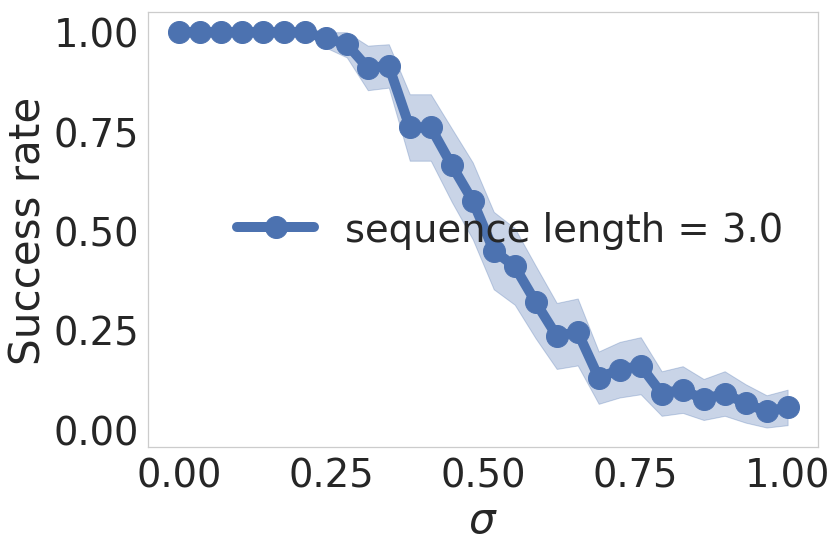

In [7]:
index = 0
ax = None
label = r'sequence length = ' + str(sequence_overlap * 10)
results_dictionary = results_dic
ax = plot_mean_success_vs_sigma(results_dictionary, n_samples=n_samples, index=index, label=label, ax=ax)

#### Single trace

In [8]:
%%time 
sigma_out = 0.2
tau_z_pre = 0.050
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 20
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 1.0
resting_time = 0.0
epochs = 1
T_persistence = 0.025

# Manager properties
values_to_save = ['o']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post, 
             tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random, 
             strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

# Build the representation
representation_overlap = 1.0
sequence_overlap = 0.3
patterns_per_sequence = 10
activity_representation = create_overalaped_representation(manager, representation_overlap, sequence_overlap)
representation = PatternsRepresentation(activity_representation, minicolumns=minicolumns)
inter_pulse_intervals[patterns_per_sequence - 1] = inter_sequence_interval


# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
NMDA = False
timed_input = manager.run_network_protocol_offline(protocol=protocol, NMDA=NMDA)
# Set the persistent time
manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, NMDA=NMDA)

sigma_number = 30
n_samples = 100
sigma_max = 1.0

results_dic_one = run_sigma_sweep(sigma_number, n_samples, sigma_max, manager, representation, 
                                  patterns_per_sequence, T_persistence=T_persistence, remove=remove, n_cues=2, NMDA=NMDA)

CPU times: user 39min 14s, sys: 3.01 s, total: 39min 17s
Wall time: 39min 16s


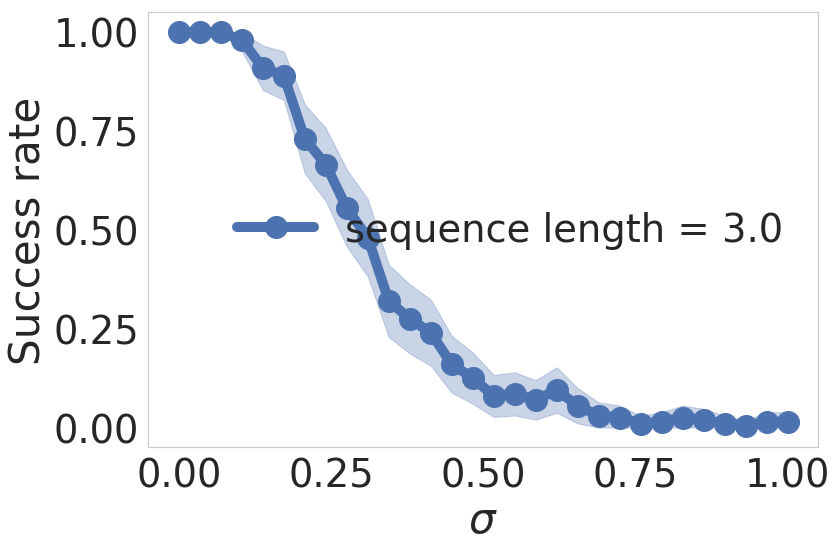

In [9]:
index = 0
ax = None
label = r'sequence length = ' + str(sequence_overlap * 10)
results_dictionary = results_dic_one
ax = plot_mean_success_vs_sigma(results_dictionary, n_samples=n_samples, index=index, label=label, ax=ax)

#### O-trace

In [10]:
%%time 
sigma_out = 0.0
tau_z_pre = 0.050
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 20
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 1.0
resting_time = 0.0
epochs = 1
T_persistence = 0.025

# Manager properties
values_to_save = ['o']

# Neural Network
nn = Network_simple(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post, 
             tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random, 
             strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

# Build the representation
representation_overlap = 1.0
sequence_overlap = 0.3
patterns_per_sequence = 10
activity_representation = create_overalaped_representation(manager, representation_overlap, sequence_overlap)
representation = PatternsRepresentation(activity_representation, minicolumns=minicolumns)
inter_pulse_intervals[patterns_per_sequence - 1] = inter_sequence_interval


# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
NMDA = False
timed_input = manager.run_network_protocol_offline(protocol=protocol, NMDA=NMDA)
# Set the persistent time
manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, NMDA=NMDA)

sigma_number = 30
n_samples = 100
sigma_max = 1.0

results_dic_o = run_sigma_sweep(sigma_number, n_samples, sigma_max, manager, representation, 
                              patterns_per_sequence, T_persistence=T_persistence, remove=remove, n_cues=2, NMDA=NMDA)

CPU times: user 39min 57s, sys: 1.1 s, total: 39min 58s
Wall time: 39min 58s


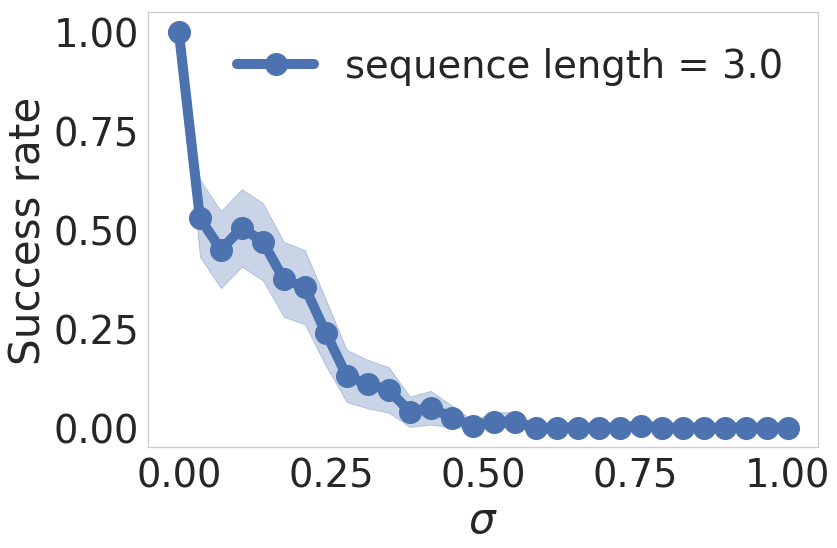

In [11]:
index = 0
ax = None
label = r'sequence length = ' + str(sequence_overlap * 10)
results_dictionary = results_dic_o
ax = plot_mean_success_vs_sigma(results_dictionary, n_samples=n_samples, index=index, label=label, ax=ax)

# Plot with the three together

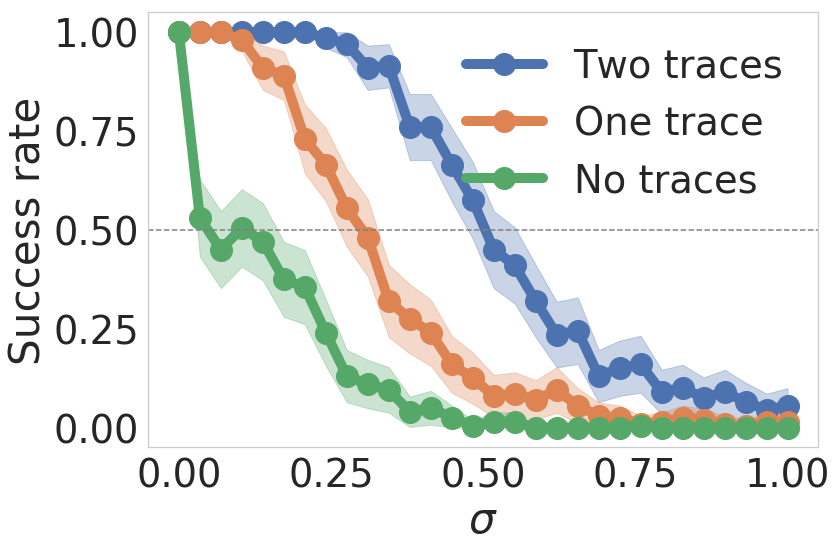

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)

label = 'Two traces'
legend = True
results_dictionary = results_dic
index = 0
ax = plot_mean_success_vs_sigma(results_dictionary, n_samples=n_samples, index=index, 
                                label=label, ax=ax, legend=legend)

results_dictionary = results_dic_one
index = 1
label = 'One trace'
ax = plot_mean_success_vs_sigma(results_dictionary, n_samples=n_samples, index=index, 
                                label=label, ax=ax, legend=legend)

index = 2
results_dictionary = results_dic_o
label = 'No traces'
ax = plot_mean_success_vs_sigma(results_dictionary, n_samples=n_samples, index=index, 
                                label=label, ax=ax, legend=legend)

ax.axhline(0.5, ls='--', color='gray') 

directory = '../plot_producers/'
file_name = 'three_examples' 
format_string = '.svg'
string_to_save = directory + file_name + format_string
fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight', transparent=True)

# No trace

CPU times: user 268 ms, sys: 32 ms, total: 300 ms
Wall time: 114 ms


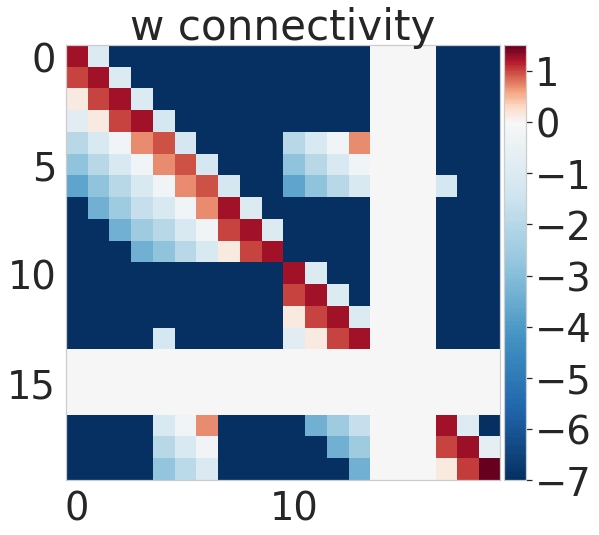

In [12]:
%%time 
sigma_out = 0.0
tau_z_pre = 0.050
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 20
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 1.0
resting_time = 0.0
epochs = 1
T_persistence = 0.025

# Manager properties
values_to_save = ['o', 's']

# Neural Network
nn = Network_simple(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post, 
             tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random, 
             strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

# Build the representation
representation_overlap = 1.0
sequence_overlap = 0.3
patterns_per_sequence = 10
activity_representation = create_overalaped_representation(manager, representation_overlap, sequence_overlap)
representation = PatternsRepresentation(activity_representation, minicolumns=minicolumns)
inter_pulse_intervals[patterns_per_sequence - 1] = inter_sequence_interval


# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
NMDA = False
timed_input = manager.run_network_protocol_offline(protocol=protocol, NMDA=NMDA)
# Set the persistent time
manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, NMDA=NMDA)

plot_weight_matrix(manager)

In [13]:
representation.activity_representation

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [ 4],
       [ 5],
       [ 6],
       [17],
       [18],
       [19]])

1.0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8]
[0.036000000000000004, 0.027, 0.027, 0.027, 0.027, 0.027, 0.045, 0.027, 0.027, 0.215, 0.044]


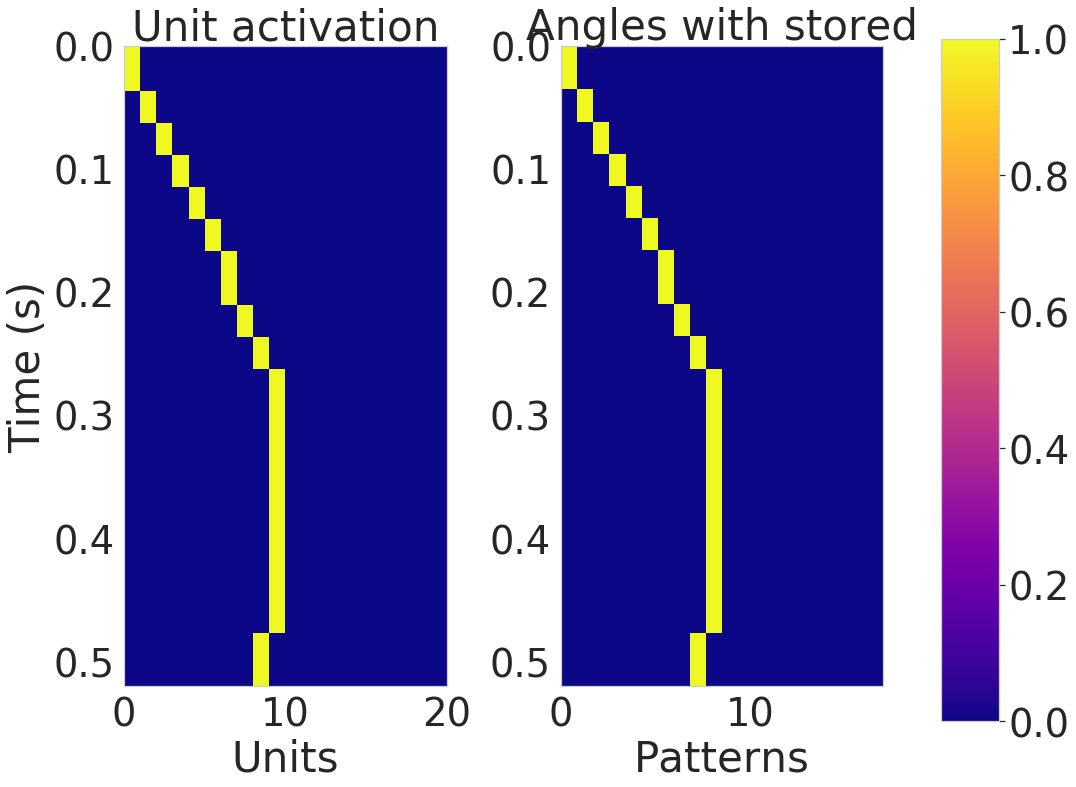

In [14]:
T_cue = 1 * manager.nn.tau_s
T_recall = 2 * T_persistence * patterns_per_sequence + T_cue

nr1 = representation.network_representation[:patterns_per_sequence]
nr2 = representation.network_representation[patterns_per_sequence:]

# Success 1
aux1 = calculate_recall_quantities(manager, nr1, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success1, pattern_sequence1, persistent_times1, timings1 = aux1
print(success1)
print(pattern_sequence1)
print(persistent_times1)

plot_network_activity_angle(manager, time_y=True);

1.0
[10, 11, 12, 13, 4, 5, 6, 17, 18, 19, 18]
[0.036000000000000004, 0.027, 0.027, 0.027, 0.027, 0.027, 0.045, 0.027, 0.028, 0.212, 0.046]


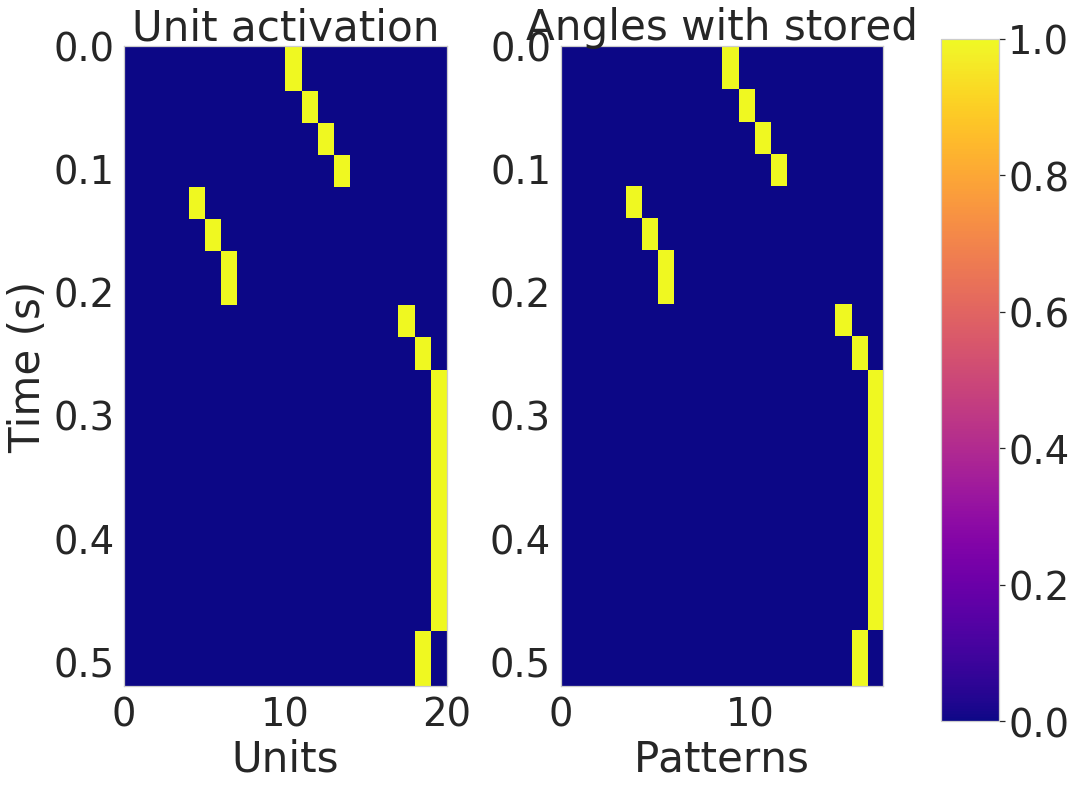

In [15]:
# Success 2
aux2 = calculate_recall_quantities(manager, nr2, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success2, pattern_sequence2, persistent_times2, timings2 = aux2
print(success2)
print(pattern_sequence2)
print(persistent_times2)

plot_network_activity_angle(manager, time_y=True);